In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from collections import defaultdict
import pandas as pd
import copy

In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [4]:
TD_ON_POLICY_SARSA = 0
TD_ON_POLICY_EXPECTED_SARSA = 1
TD_OFF_POLICY_EXPECTED_GREEDY_SARSA = 2
TD_ON_POLICY_TREE_BACKUP = 3

class td_cartpole():
    def __init__(self, seed=0, num_bins=10, eps=0.05, gamma=0.9, alpha=0.05, n=0, MODE=TD_ON_POLICY_SARSA):
        self.MODE = MODE
        self.rand = np.random
        self.rand.seed(seed)
        self.lasting = []
        self.env = gym.make("MountainCar-v0")
        self.obs = self.env.reset()
        self.num_bins = num_bins
        self.bin = self.init_bin()
        self.total_states = num_bins ** 2
        self.total_actions = self.env.action_space.n

        self.eps = eps
        self.gamma = gamma
        self.alpha = alpha
        self.n = n

        self.init_Q()
        self.init_pi()
        self.St = np.zeros((n+1), dtype=int)
        self.At = np.zeros((n+1), dtype=int)
        self.Rt = np.zeros((n+1), dtype=int)
        print("Mountain Car Env initialized, total states: %d, total actions: %d" % (self.total_states, self.total_actions))
        return

    def init_bin(self):
        num_bins = self.num_bins
        bin = np.array([np.linspace(-1.2, 0.6, num_bins+1), np.linspace(-0.07, 0.07, num_bins+1)])
        return bin

    def init_Q(self):
        self.Q = self.rand.random([self.total_states, self.total_actions])
        return self.Q

    def init_pi(self):
        eps_soft1 = 1 - self.eps + (self.eps / self.total_actions)
        eps_soft2 = self.eps / self.total_actions

        self.pi = np.ones_like(self.Q)
        self.pi *= eps_soft2
        self.pi[range(0,self.total_states), np.argmax(self.Q, axis=1)] = eps_soft1
        return self.pi

    def update_pi(self, state):
        eps_soft1 = 1 - self.eps + (self.eps / self.total_actions)
        eps_soft2 = self.eps / self.total_actions

        self.pi[state, :] = np.ones_like(self.pi[state, :])
        self.pi[state, :] *= eps_soft2
        self.pi[state, np.argmax(self.Q[state, :])] = eps_soft1
        return

    def to_state(self, obs):
        state_arr = []
        dim = self.bin.shape[1]
        for i, b in enumerate(self.bin):
            temp = np.digitize(obs[i], b)
            if temp == 0:
                state_arr.append(0)
            elif temp == dim:
                state_arr.append(dim-2)
            else:
                state_arr.append(temp-1)
        state_arr = np.array(state_arr)
        state = (state_arr[0] * (dim-1) ** 1 + state_arr[1])
        return state

    def pi2A(self, state, greedy=False):
        if not greedy:
            action = np.random.choice(self.total_actions, p=self.pi[state, :])
        else:
            action = np.argmax(self.pi[state, :])
        return action

    def IDx(self, index):
        return index % (self.n + 1)

    def tdn_on_policy_sarsa_train(self, obs):
        self.St[self.IDx(0)] = self.to_state(obs)
        self.At[self.IDx(0)] = self.pi2A(self.St[self.IDx(0)])
        T = np.inf
        t = 0
        while True:
            if t < T:
                obs, r, terminal, _ = self.env.step(self.At[self.IDx(t)])
                self.Rt[self.IDx(t+1)] = r
                self.St[self.IDx(t+1)] = self.to_state(obs)
                if terminal:
                    T = t + 1
                else:
                    self.At[self.IDx(t+1)] = self.pi2A(self.St[self.IDx(t+1)])
            tau = t - self.n + 1
            if tau >= 0:
                G = 0
                for i in range(tau+1, min(tau+self.n, T)+1):
                    G += pow(self.gamma, i - tau - 1) * self.Rt[self.IDx(i)]
                if tau + self.n < T:
                    G += pow(self.gamma, self.n) * self.Q[self.St[self.IDx(tau+self.n)], self.At[self.IDx(tau+self.n)]]
                self.Q[self.St[self.IDx(tau)], self.At[self.IDx(tau)]] += self.alpha * (G - self.Q[self.St[self.IDx(tau)], self.At[self.IDx(tau)]])
                self.update_pi(self.St[self.IDx(tau)])
            t += 1
            if tau >= T-1:
                break
        return t

    def tdn_on_policy_tree_bkup_train(self, obs):
        self.St[self.IDx(0)] = self.to_state(obs)
        self.At[self.IDx(0)] = self.pi2A(self.St[self.IDx(0)])
        T = np.inf
        t = 0
        while True:
            if t < T:
                obs, r, terminal, _ = self.env.step(self.At[self.IDx(t)])
                self.Rt[self.IDx(t+1)] = r
                self.St[self.IDx(t+1)] = self.to_state(obs)
                if terminal:
                    T = t + 1
                else:
                    self.At[self.IDx(t+1)] = self.pi2A(self.St[self.IDx(t+1)])
            tau = t - self.n + 1
            if tau >= 0:
                G = 0
                if t + 1 >= T:
                    G = self.Rt[self.IDx(T)]
                else:
                    G = self.Rt[self.IDx(t+1)] + self.gamma * np.dot(self.pi[self.St[self.IDx(t+1)]], self.Q[self.St[self.IDx(t+1)]])
                for k in range(min(t, T-1), tau+1-1, -1):
                    if self.At[self.IDx(t)] != self.At[self.IDx(k)]:
                        tempvec = copy.deepcopy(self.pi[self.St[self.IDx(k)]])
                        tempvec[self.At[self.IDx(k)]] = 0
                        treesum = np.dot(tempvec, self.Q[self.St[self.IDx(k)]])
                        G = self.Rt[self.IDx(k)] + self.gamma * treesum + self.gamma * self.pi[self.St[self.IDx(k)], self.At[self.IDx(k)]]
                self.Q[self.St[self.IDx(tau)], self.At[self.IDx(tau)]] += self.alpha * (G - self.Q[self.St[self.IDx(tau)], self.At[self.IDx(tau)]])
                self.update_pi(self.St[self.IDx(tau)])
            t += 1
            if tau >= T-1:
                break
        return t

    def td0_on_policy_sarsa_train(self, obs):
        S = self.to_state(obs)
        A = self.pi2A(S)
        t = 0
        terminal = False
        while not terminal:
            obs_, R, terminal, _ = self.env.step(A)
            S_ = self.to_state(obs_)
            A_ = self.pi2A(S_)
            self.Q[S,A] += self.alpha * (R + self.gamma * self.Q[S_,A_] - self.Q[S,A])
            self.update_pi(S)
            S = S_
            A = A_
            t += 1
        return t

    def td0_on_policy_exp_sarsa_train(self, obs):
        S = self.to_state(obs)
        A = self.pi2A(S)
        t = 0
        terminal = False
        while not terminal:
            obs_, R, terminal, _ = self.env.step(A)
            S_ = self.to_state(obs_)
            A_ = self.pi2A(S_)
            exp = np.dot(self.pi[S_], self.Q[S_])
            self.Q[S,A] += self.alpha * (R + self.gamma * exp - self.Q[S,A])
            self.update_pi(S)
            S = S_
            A = A_
            t += 1
        return t

    def td0_off_policy_greedy_exp_sarsa_train(self, obs):
        S = self.to_state(obs)
        A = self.pi2A(S)
        t = 0
        terminal = False
        while not terminal:
            obs_, R, terminal, _ = self.env.step(A)
            S_ = self.to_state(obs_)
            A_ = self.pi2A(S_)
            greedy = np.max(self.Q[S_])
            self.Q[S,A] += self.alpha * (R + self.gamma * greedy - self.Q[S,A])
            self.update_pi(S)
            S = S_
            A = A_
            t += 1
        return t

    def test_policy(self, runs=100):
        self.test_lasted = []
        self.test_return_list = []
        for r in range(runs):
            obs = self.env.reset()
            t = 0
            total_reward = 0
            terminal = False
            while not terminal:
                S = self.to_state(obs)
                A = self.pi2A(S, greedy=True)
                obs, R, terminal, _ = self.env.step(A)
                t += 1
                total_reward += R
            self.test_lasted.append(t)
            self.test_return_list.append(total_reward)

    def train(self, episodes=1):
        self.lasted = []
        for e in range(episodes):
            obs = self.env.reset()
            if self.n > 0:
                if self.MODE == TD_ON_POLICY_SARSA:
                    t = self.tdn_on_policy_sarsa_train(obs)
                elif self.MODE == TD_ON_POLICY_TREE_BACKUP:
                    t = self.tdn_on_policy_tree_bkup_train(obs)
                else:
                    assert False, "unknown MODE"
                
            else:
                if self.MODE == TD_ON_POLICY_SARSA:
                    t = self.td0_on_policy_sarsa_train(obs)
                elif self.MODE == TD_ON_POLICY_EXPECTED_SARSA:
                    t = self.td0_on_policy_exp_sarsa_train(obs)
                elif self.MODE == TD_OFF_POLICY_EXPECTED_GREEDY_SARSA:   
                    t = self.td0_off_policy_greedy_exp_sarsa_train(obs)
                else:
                    assert False, "unknown MODE"
                
            self.lasted.append(t)
            print("%d/%d episode, lasting: %d" % (e, episodes, t))
            ipythondisplay.clear_output(wait=True)
        return

    def get_SMA(self, data, SMA=100):
        df = pd.DataFrame(data)
        df['sma'] = df.rolling(window=SMA).mean()
        return df['sma']

Average return for TD(0) on-policy SARSA over 100 runs are: -167.4400


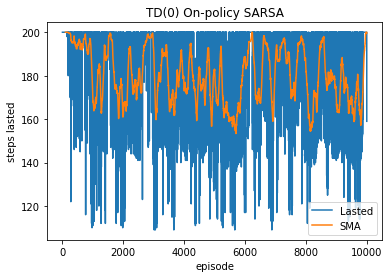

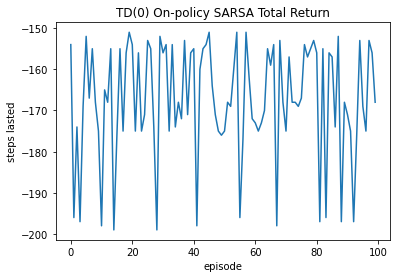

In [5]:
td0_on_sarsa = td_cartpole(n=0,MODE=TD_ON_POLICY_SARSA)
td0_on_sarsa.train(episodes=10000)
plt.plot(td0_on_sarsa.lasted)
plt.plot(td0_on_sarsa.get_SMA(td0_on_sarsa.lasted))
plt.legend(("Lasted", "SMA"))
plt.title("TD(0) On-policy SARSA")
plt.xlabel("episode")
plt.ylabel("steps lasted")

td0_on_sarsa.test_policy()
plt.figure()
plt.plot(td0_on_sarsa.test_return_list)
plt.title("TD(0) On-policy SARSA Total Return")
plt.xlabel("episode")
plt.ylabel("steps lasted")
print("Average return for TD(0) on-policy SARSA over 100 runs are: %.4f" % np.mean(td0_on_sarsa.test_return_list))

Average return for TD(0) on-policy expected SARSA over 100 runs are: -168.9700


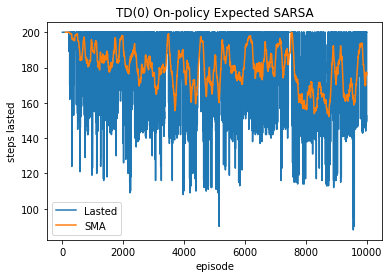

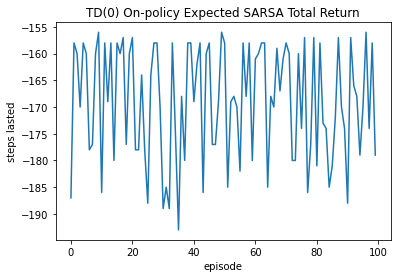

In [6]:
td0_on_exp_sarsa = td_cartpole(n=0,MODE=TD_ON_POLICY_EXPECTED_SARSA)
td0_on_exp_sarsa.train(episodes=10000)
plt.plot(td0_on_exp_sarsa.lasted)
plt.plot(td0_on_exp_sarsa.get_SMA(td0_on_exp_sarsa.lasted))
plt.legend(("Lasted", "SMA"))
plt.title("TD(0) On-policy SARSA")
plt.title("TD(0) On-policy Expected SARSA")
plt.xlabel("episode")
plt.ylabel("steps lasted")

td0_on_exp_sarsa.test_policy()
plt.figure()
plt.plot(td0_on_exp_sarsa.test_return_list)
plt.title("TD(0) On-policy Expected SARSA Total Return")
plt.xlabel("episode")
plt.ylabel("steps lasted")
print("Average return for TD(0) on-policy expected SARSA over 100 runs are: %.4f" % np.mean(td0_on_exp_sarsa.test_return_list))

Average return for TD(0) off-policy greedy expected SARSA over 100 runs are: -198.6100


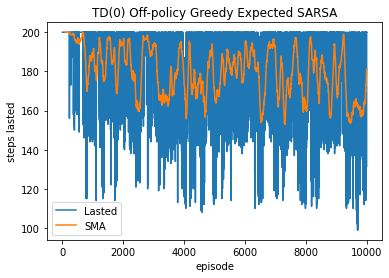

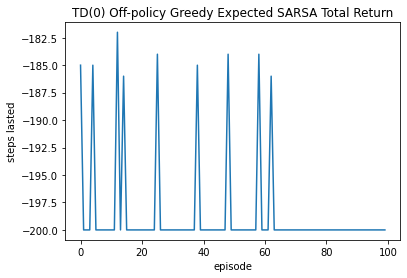

In [7]:
td0_off_exp_gdy_sarsa = td_cartpole(n=0,MODE=TD_OFF_POLICY_EXPECTED_GREEDY_SARSA)
td0_off_exp_gdy_sarsa.train(episodes=10000)
plt.plot(td0_off_exp_gdy_sarsa.lasted)
plt.plot(td0_off_exp_gdy_sarsa.get_SMA(td0_off_exp_gdy_sarsa.lasted))
plt.legend(("Lasted", "SMA"))
plt.title("TD(0) Off-policy Greedy Expected SARSA")
plt.xlabel("episode")
plt.ylabel("steps lasted")

td0_off_exp_gdy_sarsa.test_policy()
plt.figure()
plt.plot(td0_off_exp_gdy_sarsa.test_return_list)
plt.title("TD(0) Off-policy Greedy Expected SARSA Total Return")
plt.xlabel("episode")
plt.ylabel("steps lasted")
print("Average return for TD(0) off-policy greedy expected SARSA over 100 runs are: %.4f" % np.mean(td0_off_exp_gdy_sarsa.test_return_list))

Average return for TD(2) on-policy SARSA over 100 runs are: -200.0000


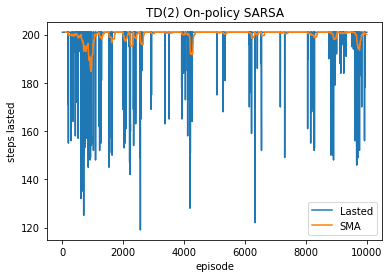

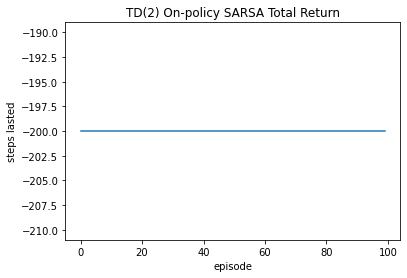

In [8]:
td2_on_sarsa = td_cartpole(n=2,MODE=TD_ON_POLICY_SARSA)
td2_on_sarsa.train(episodes=10000)
plt.plot(td2_on_sarsa.lasted)
plt.plot(td2_on_sarsa.get_SMA(td2_on_sarsa.lasted))
plt.legend(("Lasted", "SMA"))
plt.title("TD(2) On-policy SARSA")
plt.xlabel("episode")
plt.ylabel("steps lasted")

td2_on_sarsa.test_policy()
plt.figure()
plt.plot(td2_on_sarsa.test_return_list)
plt.title("TD(2) On-policy SARSA Total Return")
plt.xlabel("episode")
plt.ylabel("steps lasted")
print("Average return for TD(2) on-policy SARSA over 100 runs are: %.4f" % np.mean(td2_on_sarsa.test_return_list))

Average return for TD(3) on-policy SARSA over 100 runs are: -191.2500


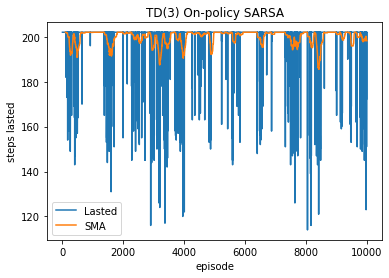

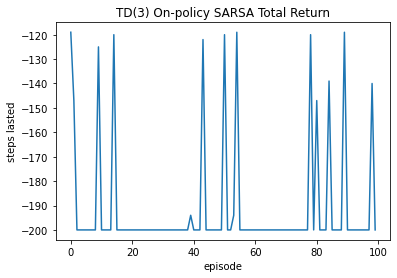

In [9]:
td3_on_sarsa = td_cartpole(n=3,MODE=TD_ON_POLICY_SARSA)
td3_on_sarsa.train(episodes=10000)
plt.plot(td3_on_sarsa.lasted)
plt.plot(td3_on_sarsa.get_SMA(td3_on_sarsa.lasted))
plt.legend(("Lasted", "SMA"))
plt.title("TD(3) On-policy SARSA")
plt.xlabel("episode")
plt.ylabel("steps lasted")

td3_on_sarsa.test_policy()
plt.figure()
plt.plot(td3_on_sarsa.test_return_list)
plt.title("TD(3) On-policy SARSA Total Return")
plt.xlabel("episode")
plt.ylabel("steps lasted")
print("Average return for TD(3) on-policy SARSA over 100 runs are: %.4f" % np.mean(td3_on_sarsa.test_return_list))

Average return for TD(4) on-policy SARSA over 100 runs are: -200.0000


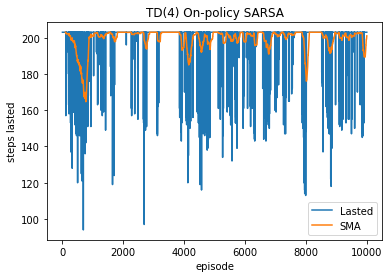

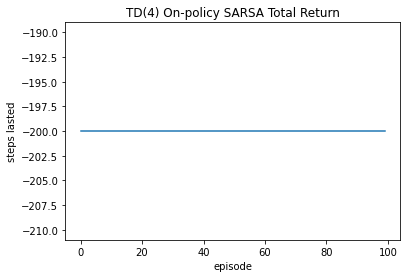

In [10]:
td4_on_sarsa = td_cartpole(n=4,MODE=TD_ON_POLICY_SARSA)
td4_on_sarsa.train(episodes=10000)
plt.plot(td4_on_sarsa.lasted)
plt.plot(td4_on_sarsa.get_SMA(td4_on_sarsa.lasted))
plt.legend(("Lasted", "SMA"))
plt.title("TD(4) On-policy SARSA")
plt.xlabel("episode")
plt.ylabel("steps lasted")

td4_on_sarsa.test_policy()
plt.figure()
plt.plot(td4_on_sarsa.test_return_list)
plt.title("TD(4) On-policy SARSA Total Return")
plt.xlabel("episode")
plt.ylabel("steps lasted")
print("Average return for TD(4) on-policy SARSA over 100 runs are: %.4f" % np.mean(td4_on_sarsa.test_return_list))

Average return for TD(2) on-policy tree backup over 100 runs are: -172.7900


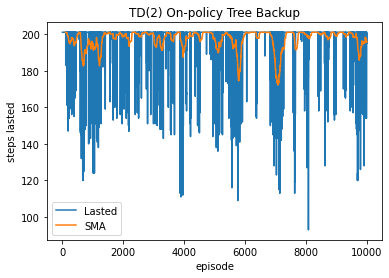

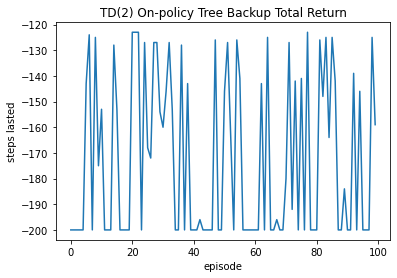

In [11]:
td2_on_policy_tree_bkup = td_cartpole(n=2,MODE=TD_ON_POLICY_TREE_BACKUP)
td2_on_policy_tree_bkup.train(episodes=10000)
plt.plot(td2_on_policy_tree_bkup.lasted)
plt.plot(td2_on_policy_tree_bkup.get_SMA(td2_on_policy_tree_bkup.lasted))
plt.legend(("Lasted", "SMA"))
plt.title("TD(2) On-policy Tree Backup")
plt.xlabel("episode")
plt.ylabel("steps lasted")

td2_on_policy_tree_bkup.test_policy()
plt.figure()
plt.plot(td2_on_policy_tree_bkup.test_return_list)
plt.title("TD(2) On-policy Tree Backup Total Return")
plt.xlabel("episode")
plt.ylabel("steps lasted")
print("Average return for TD(2) on-policy tree backup over 100 runs are: %.4f" % np.mean(td2_on_policy_tree_bkup.test_return_list))

Average return for TD(3) on-policy tree backup over 100 runs are: -200.0000


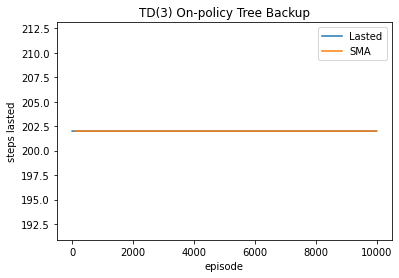

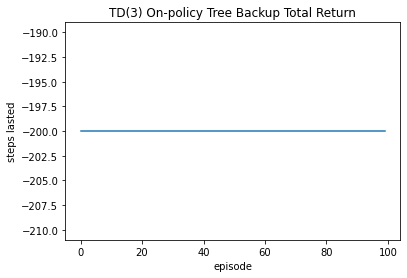

In [12]:
td3_on_policy_tree_bkup = td_cartpole(n=3,MODE=TD_ON_POLICY_TREE_BACKUP)
td3_on_policy_tree_bkup.train(episodes=10000)
plt.plot(td3_on_policy_tree_bkup.lasted)
plt.plot(td3_on_policy_tree_bkup.get_SMA(td3_on_policy_tree_bkup.lasted))
plt.legend(("Lasted", "SMA"))
plt.title("TD(3) On-policy Tree Backup")
plt.xlabel("episode")
plt.ylabel("steps lasted")

td3_on_policy_tree_bkup.test_policy()
plt.figure()
plt.plot(td3_on_policy_tree_bkup.test_return_list)
plt.title("TD(3) On-policy Tree Backup Total Return")
plt.xlabel("episode")
plt.ylabel("steps lasted")
print("Average return for TD(3) on-policy tree backup over 100 runs are: %.4f" % np.mean(td3_on_policy_tree_bkup.test_return_list))

Average return for TD(4) on-policy tree backup over 100 runs are: -200.0000


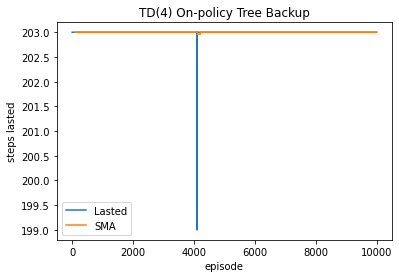

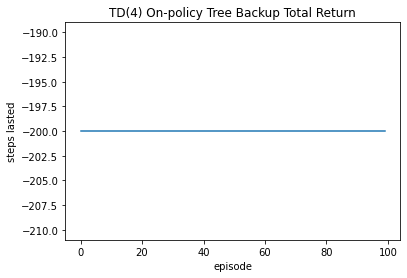

In [13]:
td4_on_policy_tree_bkup = td_cartpole(n=4,MODE=TD_ON_POLICY_TREE_BACKUP)
td4_on_policy_tree_bkup.train(episodes=10000)
plt.plot(td4_on_policy_tree_bkup.lasted)
plt.plot(td4_on_policy_tree_bkup.get_SMA(td4_on_policy_tree_bkup.lasted))
plt.legend(("Lasted", "SMA"))
plt.title("TD(4) On-policy Tree Backup")
plt.xlabel("episode")
plt.ylabel("steps lasted")

td4_on_policy_tree_bkup.test_policy()
plt.figure()
plt.plot(td4_on_policy_tree_bkup.test_return_list)
plt.title("TD(4) On-policy Tree Backup Total Return")
plt.xlabel("episode")
plt.ylabel("steps lasted")
print("Average return for TD(4) on-policy tree backup over 100 runs are: %.4f" % np.mean(td4_on_policy_tree_bkup.test_return_list))

In [14]:
# A summerize of our findings:
print("Average total return over 100 runs:")
print("TD(0) on-policy SARSA: %.4f" % np.mean(td0_on_sarsa.test_return_list))
print("TD(0) on-policy expected SARSA: %.4f" % np.mean(td0_on_exp_sarsa.test_return_list))
print("TD(0) off-policy greedy expected SARSA: %.4f" % np.mean(td0_off_exp_gdy_sarsa.test_return_list))
print("TD(2) on-policy SARSA: %.4f" % np.mean(td2_on_sarsa.test_return_list))
print("TD(3) on-policy SARSA: %.4f" % np.mean(td3_on_sarsa.test_return_list))
print("TD(4) on-policy SARSA: %.4f" % np.mean(td4_on_sarsa.test_return_list))
print("TD(2) on-policy tree backup: %.4f" % np.mean(td2_on_policy_tree_bkup.test_return_list))
print("TD(3) on-policy tree backup: %.4f" % np.mean(td3_on_policy_tree_bkup.test_return_list))
print("TD(4) on-policy tree backup: %.4f" % np.mean(td4_on_policy_tree_bkup.test_return_list))

Average total return over 100 runs:
TD(0) on-policy SARSA: -167.4400
TD(0) on-policy expected SARSA: -168.9700
TD(0) off-policy greedy expected SARSA: -198.6100
TD(2) on-policy SARSA: -200.0000
TD(3) on-policy SARSA: -191.2500
TD(4) on-policy SARSA: -200.0000
TD(2) on-policy tree backup: -172.7900
TD(3) on-policy tree backup: -200.0000
TD(4) on-policy tree backup: -200.0000
